# Midterm 2, Fall 2021: Campaign Finance Geography #

_Version 1.0_

This problem builds on your knowledge of **Pandas, SQLite, and Sparse Matrices**. It has **7** exercises, numbered 0 to **6**. There are **13 available points.** However, to earn 100%, the threshold is just **9 points.** (Therefore, once you hit **9** points, you can stop. There is no extra credit for exceeding this threshold.)  
- Exercise 0: 1 point
- Exercise 1: 2 points
- Exercise 2: 1 point
- Exercise 3: 1 point
- Exercise 4: 3 points
- Exercise 5: 2 points
- Exercise 6: 3 points  

Each exercise builds logically on the previous one, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. Demo cells depend on data loaded in previous demo cells. **Run any demo cells before moving on.** They are annotated by `# Demo cell - run this cell before moving on.`

For more information see the "Midterm 2 Release Notes" post on the discussion forum.


**Good luck!**

<a href="mt2-fa21.html" target="_blank">Solution</a>

## Introduction

**This section merely provides context for the overall problem. If you are pressed for time, feel free to skip to the next section and start the exam by running the first code cell.**

The Federal Election Commission tracks each individual campaign contribution over $200. Among the information collected is the name and address of the person making the contribution and the committee receiving the contribution. Note that all contributions are actually made to committees. Some committees are directly connected to individual candidates, but others are more "general purpose". There are specific rules governing what each type of committee is allowed to actually spend their money on (this is well beyond the scope of this notebook).

Our goal is to use the contributors' ZIP codes and candidate committees to calculate some similarity scores. Specifically, we want to measure how similar geographic areas are based on the candidates to whom they made contributions and measure how similar candidates are based on the geographic areas that contributed to their campaigns.

We are using data pulled from the official [FEC website](https://www.fec.gov/data/browse-data/?tab=bulk-data). The individual contributions files are huge, so we have done some of the initial (and time consuming) processing for you. 

**This ends the introduction, you should read the remaining content.**

In [1]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

#from testing_tools import ...
import pandas as pd
import numpy as np
import sqlite3
from scipy.sparse import coo_matrix
import importlib
import run_tests
import pickle
import time
import geopandas as gpd

We have ingested a sample of the raw data into a SQLite database `data.db`. The first table we will be working with is named `indiv_contrib`. Each row represents a single individual campaign contribution. It has 5 columns.  

0. index - autogenerated index (synthetic key). - INTEGER
1. CMTE_ID - committee id receiving a contribution. - TEXT
2. TRANSACTION_TP - transaction type code. - TEXT
3. ZIP_CODE - ZIP code from which a contribution was made. - TEXT
4. TRANSACTION_AMT - Dollar amount of a contribution. -INTEGER
5. MEMO_CD - extra data about the transaction - Will always be `NULL` due to our preprocessing.

In [2]:
# Demo cell - run this cell before moving on.
conn = sqlite3.connect('resource/asnlib/publicdata/data.db')
pd.read_sql_query('''
    SELECT * 
    FROM indiv_contrib 
    ORDER BY random() limit 10
''', conn)

**Exercise 0** (1 points): Write a SQL query to return the **ZIP code**, **committee id**, and **total amount donated** to the committee from the ZIP code. The column names in your result should be `zip`, `cmte`, and `total`. Your results should be sorted by ZIP code with ties broken by committee id.  

Store the query as a string in a variable named `query`.

In [3]:
###
### YOUR CODE HERE
###
#query = '''YOUR QUERY HERE'''

The demo cell below should produce the following output.

```
              zip       cmte  total
245424  481898262  C00694323     13
123189  234511007  C00694323     75
70102   128351844  C00694323     23
139260  286127773  C00694323     75
219586  413110947  C00694323    100
206873  370874263  C00694323     50
89596   191037507  C00669358    500
250160      48823  C00618371    292
64827   117472016  C00042366     25
69251   125534796  C00118943     37 
```

In [4]:
# Demo cell - run this cell before moving on.
grouped_contrib = pd.read_sql_query(query, conn)
print(grouped_contrib.sample(10, random_state=6040))

In [5]:
# Test cell
importlib.reload(run_tests)
from run_tests import ex_0_check
ex_0_check(query)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [6]:
# loads variables from latest test cell run for debugging
from ex0 import test_input, test_output, your_output

An analyst looking at the results of the previous exercise realizes that she needs you to perform two more cleaning steps.

1. The zip codes are messy, and only the first 5 digits are meaningful. For example, if there were three zip codes `387592829`, `38759`, and `387591234`, these should be treated as the same as just `38759`.

2. Committee ids are only meaningful when there is a candidate associated with them. We need to cross-check these ids against a separate candidates list before including them.

You'll implement these steps in Exercise 1, using the following two tables:

 
* The table `grouped_contrib` is the entire raw dataset aggregated the same way we did in exercise 0. It will have columns named `ZIP_CODE`, `CMTE_ID`, and `TRANSACTION_AMT` indicating the ZIP code, committee id, and total transaction amount from each ZIP code - committee combination, respectively.
```
    ZIP_CODE    CMTE_ID  TRANSACTION_AMT
0  023603646  C00703975              751
1  975203608  C00633404              472
2  372062545  C00703975              250
3  940106378  C00725853              500
4  773795118  C00694323              557
```
* The table `candidate` has information about individual candidates. In particular, the `CAND_PCC` column contains the id of the committee associated with each candidate, and the `CAND_NAME` column contains each candidate's name. 
```
                  CAND_NAME   CAND_PCC
0   PATTI, TIFFANY JEAN MS.  C00737395
1  OBRIEN, JAMES RICHARD SR  C00750836
2      KRAUSE, RYAN PATRICK  C00662841
3           GUMINA, TONY DR  C00674283
4             REED, DERRICK  C00712273
```

**Exercise 1** (2 points): Write a query using the `grouped_contrib` and `candidate` tables to extract the **5-digit ZIP code**, **candidate name**, and **total amount donated from the ZIP code to the candidate**. The columns should be named `zip`, `candidate`, and `total`. Your result should be ordered by 5-digit ZIP code with ties broken by candidate names. 

You will have to aggregate again because **many** 9-digit ZIP codes will be associated with a **single** 5-digit ZIP code

The SQLite function `SUBSTR()` may be useful for dealing with the ZIP codes. The **first** 5 digits of **any** ZIP code are considered the 5-digit ZIP code.

Records with committee ids that are not associated with candidates should not be included.

Your query should be stored in a variable named `query_1`.

In [7]:
###
### YOUR CODE HERE
###
#query_1 = '''YOUR QUERY HERE'''

If your query is correct, the demo code below should output the following.
```
          zip                candidate  total
578150  73144          CAMPBELL, RAYLA    500
102645  10178          BOOKER, CORY A.   2700
133644  12136            ERNST, JONI K   1050
244940  23508             MISSO, ROGER   1100
56985   06475            PERDUE, DAVID   2335
787059  94030         WALLACE, CYNTHIA    250
732114  90720  CORTEZ MASTO, CATHERINE    300
45640   04675             DAVIS, WENDY    500
2365    01053          HARRISON, JAIME    655
34909   03049          LOEFFLER, KELLY    821

```

In [8]:
# Demo cell - run this cell before moving on.
df = pd.read_sql_query(query_1, conn)
print(df.sample(10, random_state=6040))
if False:
    with open('resource/asnlib/publicdata/df.pkl', 'wb') as f:
        pickle.dump(df, f)

In [9]:
# Test cell
importlib.reload(run_tests)
from run_tests import ex_1_check
ex_1_check(query_1)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [10]:
# loads variables from latest test cell run for debugging
from ex1 import test_input, test_output, your_output

**Exercise 2** (1 Points): We're almost done with the cleanup. The last bit is to make sure that the ZIP codes in our data are actual US ZIP codes.
Fill out the function definition for `filter_zip(df, zips)` to filter out invalid ZIP codes.
* Input `df` - a Pandas DataFrame which has a column `zip` with string values that may contain valid and/or invalid ZIP codes.
* Input `zips` - a set containing all valid ZIP codes.
* Output - a **new** DataFrame which contains all of the rows of `df` that have valid ZIP codes.

**Note** We are not checking the ordering of the output for this exercise.

In [11]:
def filter_zip(df, zips):
    ###
    ### YOUR CODE HERE
    ###


If your solution is correct, the demo cell below will produce the following output:
```
          zip               candidate   total
663334  80634              PAUL, RAND    1000
368911  35824   INHOFE, JAMES M. SEN.    6000
794373  94123  MARKEY, EDWARD J. SEN.   13406
295709  30328        BOLLIER, BARBARA     460
605547  76250        MCCONNELL, MITCH     100
25983   02468         MURKOWSKI, LISA     250
370438  36207          DAINES, STEVEN     855
795220  94131         HARRISON, JAIME  123214
532922  62536        TRUMP, DONALD J.    1010
798235  94501        TRUMP, DONALD J.   24020
```

In [12]:
# Demo cell - run this cell before moving on.
with open('resource/asnlib/publicdata/zip_code.pkl', 'rb') as f:
    zips = pickle.load(f)
with open('resource/asnlib/publicdata/df.pkl', 'rb') as f:
    df = pickle.load(f)

df_filter = filter_zip(df, zips)
if False:
    with open('resource/asnlib/publicdata/df_filter.pkl', 'wb') as f:
        pickle.dump(df_filter, f)
print(df_filter.sort_values(['zip', 'candidate']).sample(10, random_state=6040))

In [13]:
# Test Cell
importlib.reload(run_tests)
from run_tests import ex_2_check
ex_2_check(filter_zip)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [14]:
# loads variables from latest test cell run for debugging
from ex2 import test_df, test_zips, test_output, your_output

**Exercise 3** (1 point): Next, you need to map unique zip codes and unique candidates to integers. We'll use this result later when we convert the data into a sparse matrix.

Your task now is to complete the function, `calc_col_map(df, col)`. Its inputs are:
* `df`: a pandas `DataFrame`
* `col`: a Python string that is the name of one of the columns of `df`, i.e., `df[col]` is a pandas `Series`.

The function should determine the **unique** values of `df[col]`, sort them, and then assign each unique value to an integer starting at 0. It should return a Python dictionary whose keys are the unique values of `df[col]` and whose values are the assigned integers.

Your function should not attempt to clean anything or change cases when determining your ordering.

**Example:**
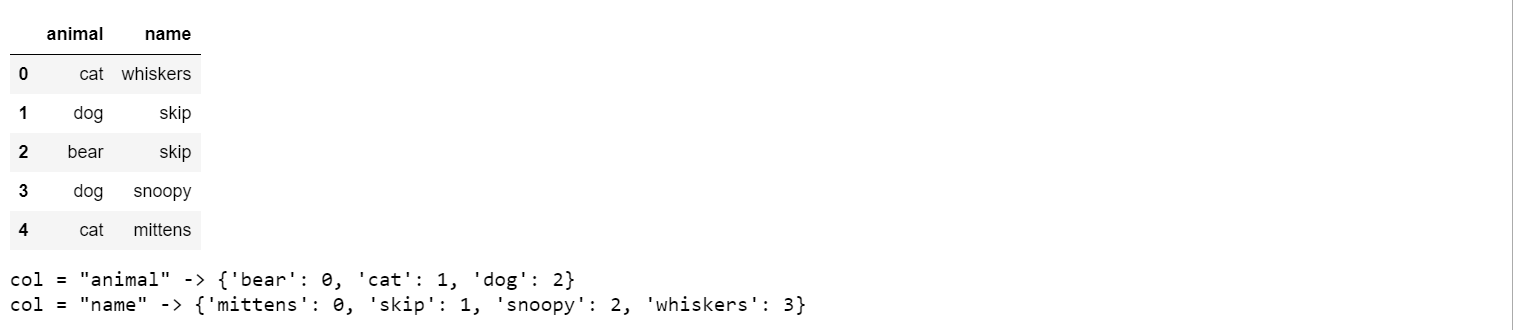

In [15]:
def calc_col_map(df, col):
    ###
    ### YOUR CODE HERE
    ###


If your solution is correct, the demo cell below should generate the following output: 

`{'BUEHLER, KNUTE': 293, 'BOYD, SAMUEL GRAHAM MR': 229, 'HIGGINBOTHAM, F MICHAEL': 1017, 'TLAIB, RASHIDA': 2262, 'SMITH, ADRIAN': 2097, 'PAUL, RAND': 1744, 'CARTER, WILLIE FELIX': 357, 'GOODEN, LANCE': 856, 'WILSON, FREDERICA S': 2458, 'WRITZ, RAY': 2488}`
 
`{'08031': 2219, '71404': 21078, '99224': 28460, '33480': 9702, '02048': 441, '62313': 18639, '83857': 24651, '91962': 26063, '94558': 26755, '18463': 5270}`

In [16]:
# Demo cell - run this cell before moving on.
with open('resource/asnlib/publicdata/df_filter.pkl', 'rb') as f:
    df_filter = pickle.load(f)
cand_map = calc_col_map(df_filter, 'candidate')
zip_map = calc_col_map(df_filter, 'zip')
cands = pd.Series(cand_map.keys()).sort_values().sample(10, random_state=6040)
zip_keys = pd.Series(zip_map.keys()).sort_values().sample(10, random_state=6040)
print({k: cand_map[k] for k in cands})
print()
print({k: zip_map[k] for k in zip_keys})
if False:
    with open('resource/asnlib/publicdata/cand_map.pkl', 'wb') as f:
        pickle.dump(cand_map, f)
    with open('resource/asnlib/publicdata/zip_map.pkl', 'wb') as f:
        pickle.dump(zip_map, f)

In [17]:
# Test Cell
importlib.reload(run_tests)
from run_tests import ex_3_check
ex_3_check(calc_col_map)
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [18]:
# loads variables from latest test cell run for debugging
from ex3 import test_df, test_col, test_output, your_output

**Exercise 4** (3 points): Suppose you are given a dataframe `df` and a column name, `col`. Suppose `df[col]` holds grouping labels and `df['total']` holds values. For instance:

``` 
   foo  total
0  qux      2
1  qux      2
2  bar      4
3  qux      1
4  bar      3
```

Complete the function `normalize_df(df, col)` so that it returns a **new copy** of `df` where each value of the `'total'` column is normalized by the **Euclidean norm** (2-norm) of its group. For example, the Euclidean norms of each group in the preceding example would be

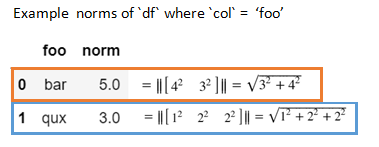

Therefore, the output of `normalize_df(df, col)` would be:
```
   foo     total
0  qux  0.666667
1  qux  0.666667
2  bar  0.800000
3  qux  0.333333
4  bar  0.600000
```

There are three important implementation notes/hints:

1. If the norm of a group is zero, do not divide by zero! Instead, you should output the value 0 in the corresponding elements of the `'total'` column.
2. `pandas.DataFrame.groupby.apply` might be more efficient on large inputs than attempting to filter based on unique values.
3. As usual, remember **not** to modify the input `df`, but return a copy (including all of the original input columns and the new normalized `'total'` column).

In [23]:
def normalize_df(df, col):
    ###
    ### YOUR CODE HERE
    ###


If your solution is correct, the demo cell below should generate the following output:
```
        zip                    candidate     total
4307  55616             MCCONNELL, MITCH  1.000000
5914  90274                  STEYER, TOM  0.331295
8689  66839         DE LA ISLA, MICHELLE  1.000000
8492  28262    OCASIO-CORTEZ, ALEXANDRIA  0.105681
2782  37923       FLEISCHMANN, CHARLES J  0.950345
1543  94301  LADJEVARDIAN, SIMA JANDAGHI  0.028958
8094  44111            KUNKEL, CATHERINE  1.000000
6003  67855            MARSHALL, ROGER W  1.000000
6507  19106              GANDHI, PRITESH  0.142335
8040  36854                  JONES, DOUG  1.000000

        zip                    candidate     total
4307  55616             MCCONNELL, MITCH  0.001762
5914  90274                  STEYER, TOM  0.129709
8689  66839         DE LA ISLA, MICHELLE  0.170617
8492  28262    OCASIO-CORTEZ, ALEXANDRIA  0.066085
2782  37923       FLEISCHMANN, CHARLES J  0.998546
1543  94301  LADJEVARDIAN, SIMA JANDAGHI  0.100375
8094  44111            KUNKEL, CATHERINE  0.050242
6003  67855            MARSHALL, ROGER W  0.266359
6507  19106              GANDHI, PRITESH  0.347734
8040  36854                  JONES, DOUG  0.048787
```

In [24]:
norm_zip_df = normalize_df(df_filter.sample(10000, random_state=6040), 'zip')
norm_cand_df = normalize_df(df_filter.sample(10000, random_state=6040), 'candidate')
if False:
    import pickle
    with open('resource/asnlib/publicdata/norm_zip_df.pkl', 'wb') as f:
        pickle.dump(norm_zip_df, f)
    with open('resource/asnlib/publicdata/norm_cand_df.pkl', 'wb') as f:
        pickle.dump(norm_cand_df, f)
print(norm_zip_df.sort_values(by=['zip', 'candidate']).sample(10, random_state=6040))
print()
print(norm_cand_df.sort_values(by=['zip', 'candidate']).sample(10, random_state=6040))


In [25]:
# Test Cell
importlib.reload(run_tests)
from run_tests import ex_4_check
ex_4_check(normalize_df)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [26]:
# loads variables from latest test cell run for debugging
from ex4 import test_df, test_col, test_output, your_output

**Exercise 5** (2 points): Now that we have our maps, we can convert our dataframes to coordinate (COO) sparse matrices.

Suppose you are given the following inputs:
- `df`, an input dataframe with **three columns**
- `map_row`, a dictionary that can be used to convert values in column 0 of `df` (i.e., `df.iloc[:, 0]`) into integers
- `map_col`, a dictionary that can be used to convert values in column 1 of `df` into integers

Complete the function `df_to_coo(df, map_row, map_col)` so that it constructs and returns a Scipy COO matrix ([`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix)) constructed from its inputs. In particular:

1. Each row in `df` should become one entry in the output sparse matrix. The row index comes from column 0 of `df` (remapped via `map_row`) and the column index from column 1 of `df` (remapped via `map_col`).
2. The shape should be $m \times n$ where $m$ is the length of `map_row` and $n$ is the length of `map_col`.
3. The value of each matrix entry comes from column 2 of `df`.

> Note that the _names_ of the columns of `df` are arbitrary; per the instructions above, your code should reference them by their position.

In [27]:
def df_to_coo(df, map_row, map_col):
    ###
    ### YOUR CODE HERE
    ###


If your answer is correct, the following demo should print the following output:

```
         row    col      data
634060  1744  24026  0.011377
353573  1093  10346  0.032794
755238  1415  26690  0.027885
285296   213   8667  0.000531
580564  1471  22553  0.000132
24762   1600    553  0.005811
354965   536  10448  0.001325
756044   962  26696  0.066272
512580  2281  18725  0.000422
758775  2281  26710  0.010037

          row   col      data
634060  24026  1744  0.005304
353573  10346  1093  0.349865
755238  26690  1415  0.020812
285296   8667   213  0.001407
580564  22553  1471  0.039134
24762     553  1600  0.000867
354965  10448   536  0.014877
756044  26696   962  0.147149
512580  18725  2281  0.550480
758775  26710  2281  0.059602
```

In [28]:
# Demo cell - run this cell before moving on.
with open('resource/asnlib/publicdata/zip_map.pkl', 'rb') as f:
    zip_map = pickle.load(f)
with open('resource/asnlib/publicdata/cand_map.pkl', 'rb') as f:
    cand_map = pickle.load(f)
with open('resource/asnlib/publicdata/norm_zip_df.pkl', 'rb') as f:
    norm_zip_df = pickle.load(f)
with open('resource/asnlib/publicdata/norm_cand_df.pkl', 'rb') as f:
    norm_cand_df = pickle.load( f)

zip_coo = df_to_coo(norm_zip_df[['zip', 'candidate', 'total']], zip_map, cand_map)
cand_coo = df_to_coo(norm_cand_df[['candidate', 'zip', 'total']], cand_map, zip_map)

demo_cand_df = pd.DataFrame({'row': cand_coo.row, 'col': cand_coo.col, 'data': cand_coo.data}).reset_index(drop=True).sort_values(['row', 'col'])
demo_zip_df = pd.DataFrame({'row': zip_coo.row, 'col': zip_coo.col, 'data': zip_coo.data}).reset_index(drop=True).sort_values(['row', 'col'])
inds = pd.Series(demo_zip_df.index).sample(10, random_state=6040)
print(demo_cand_df.loc[inds, :])
print()
print(demo_zip_df.loc[inds, :])
if False:
    with open('resource/asnlib/publicdata/zip_coo.pkl', 'wb') as f:
        pickle.dump(zip_coo, f)
    with open('resource/asnlib/publicdata/cand_coo.pkl', 'wb') as f:
        pickle.dump(cand_coo, f)

In [29]:
# Test Cell
importlib.reload(run_tests)
from run_tests import ex_5_check
ex_5_check(df_to_coo)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [30]:
# loads variables from latest test cell run for debugging
from ex5 import test_df, test_row_map, test_col_map, test_output, your_output

Suppose you have a bunch of data points and you want to measure how "similar" they are to one another. Here is an efficient method.

Suppose the data are arranged into a sparse matrix $A$ where every row is a (row) vector that represents one data point. Let $a_i^T$ denote the $i$-th row. Further suppose that every row is normalized, i.e., $\|a_i\|=1$. Then one way to measure how similar two rows $i$ and $j$ are to one another is to use a metric called **cosine similarity,** calculated as
$$
\mbox{cosine-similarity}(a_i, a_j) = a_i^T a_j,
$$
that is, the dot product of row $i$ and row $j$.

Note that if you want to calculate the similarity of row $i$ to **every** row of $A$, you can do that simply by calculating the vector-times-matrix product, $a_i^T A^T$.

**Exercise 6** (3 points): Suppose you are given the following inputs:

- `mat`: A Scipy sparse matrix in COO format. This matrix might have come from Exercise 5, for instance.
- `map_row`: A Python dictionary mapping items (like zip codes or candidates) to integer indices. It might have come from Exercise 3 or been an input to Exercise 5.
- `target`: A string holding the name of one of the items (keys) in `map_row`.

Complete the function `calc_similarity(mat, row_map, target)`, below, so that it does the following:

1. Determines the row of `mat` corresponding to `target`.
2. Computes the cosine similarity between that row and every row in `mat`.
3. Constructs a pandas `DataFrame` containing two columns:
    * Column `'key'`, which holds item names
    * Column `'similarity'`, which holds the similarity score between the `target` row and the corresponding item (`'key'` value).
4. Returns the dataframe, with its rows **sorted** in **descending** order of similarity score.


In [ ]:
def calc_similarity(mat, row_map, target):
    ###
    ### YOUR CODE HERE
    ###


If your solution is correct, the following demo should generate this output:

```
                          key  similarity
293   OBERWEIS, JAMES D "JIM"    0.147660
229            SESSIONS, PETE    0.170213
1017             GAPP, JOSHUA    0.054942
2262           DUNCAN, DARREN    0.004347
2097   SCAIFE, DELANO MICHAEL    0.008567
1744        LEMAY, ERIC N MR.    0.018798
357          BARRASSO, JOHN A    0.132881
856           MARTINEZ, ELISA    0.068399
2458        BRITTAIN, CRAIG R    0.000731
2488    YACUS, GEORGE MICHAEL    0.000205

         key  similarity
2219   93940    0.329976
21078  73942    0.024668
28460  59647    0.000000
9702   20650    0.204070
441    72583    0.455126
18639  41097    0.058839
24651  04758    0.000000
26063  64497    0.000000
26755  74472    0.000000
5270   33434    0.259837
```

In [ ]:
# Demo cell - run this cell before moving on.
with open('resource/asnlib/publicdata/zip_coo.pkl', 'rb') as f:
    zip_coo = pickle.load(f)
with open('resource/asnlib/publicdata/cand_coo.pkl', 'rb') as f:
    cand_coo = pickle.load(f)

cand_sim_df = calc_similarity(cand_coo, cand_map, 'TRUMP, DONALD J.')
zip_sim_df = calc_similarity(zip_coo, zip_map, '30332')
print(cand_sim_df.sample(10, random_state=6040))
print()
print(zip_sim_df.sample(10, random_state=6040))
if False:
    with open('resource/asnlib/publicdata/cand_sim_df.pkl', 'wb') as f:
        pickle.dump(cand_sim_df, f)
    with open('resource/asnlib/publicdata/zip_sim_df.pkl', 'wb') as f:
        pickle.dump(zip_sim_df, f)

In [ ]:
# Test Cell
importlib.reload(run_tests)
from run_tests import ex_6_check
ex_6_check(calc_similarity)

###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [ ]:
from ex6 import test_mat, test_row_map, test_target, true_output, your_output
# print(test_mat, test_row_map, test_target, true_output, your_output, sep='\n\n')

**Epilogue**

There are no more exercises after this point. The remaining content is to demonstrate useful ways to actually use the functions you have written above. Feel free to skip this content if you aren't interested.

**Augmenting Candidate Similarity**

If you recall from above, our database connection had a `candidate` table from which we pulled candidate names. This table has some more useful information. See the query/results below for an idea of what's in there.

In [ ]:
pd.read_sql('select * from candidate limit 1', conn)

**Function description**: `candidate_merge(sim_df, conn)`
* Input - `sim_df` - Pandas DataFrame with columns 
  * `'key'` (candidate names)
  * `'similarity'` (similarity scores)
* Input - `conn` - database connection. We assume that it has a table `candidates` structured as above.
* Output - DataFrame with the following columns
  * `'candidate'` - name of the candidate
  * `'party'` - candidate's party affiliation
  * `'office'` - office for which the candidate is running
  * `'state'` - state where the candidate is running for office (Use the column with office in the name)
  * `'district'` - district within a state where the candidate is running for office
  * `'similarity'` - similarity score associated with the candidate
  
We use `merge` to join the similarity scores to the candidate data to provide richer data for analysis.

In [ ]:
def candidate_merge(sim_df, conn):
    md_df = pd.read_sql_query('''
    select 
        CAND_NAME as candidate, 
        CAND_PTY_AFFILIATION as party,
        CAND_OFFICE as office, 
        CAND_OFFICE_ST as state, 
        CAND_OFFICE_DISTRICT as district 
    from candidate;
    ''', conn)
    return md_df.merge(sim_df, left_on='candidate', right_on='key')\
        .drop(columns='key')\
        .sort_values(['similarity'], ascending=False).reset_index(drop=True)

Below is a demo with the 10 candidates most similar to the candidate 'TRUMP, DONALD J.'

In [ ]:
with open('resource/asnlib/publicdata/cand_sim_df.pkl', 'rb') as f:
    cand_sim_df = pickle.load(f)
print(candidate_merge(cand_sim_df, conn).head(10))

**Augmenting Zip Code Similarity**

Below, we will demonstrate augmenting ZIP code similarity scores with geographical data and drawing choropleths (color coded maps). The cell below loads two GeoPandas GeoDataFrame objects with geography information about US states and US ZIP codes.

In [ ]:
import geopandas as gpd
if False:
    zipcode_gdf = gpd.read_file(f"zip://resource/asnlib/publicdata/tl_2017_us_zcta510.zip")
    states_gdf = gpd.read_file(f"zip://resource/asnlib/publicdata/tl_2017_us_state.zip")
    with open('resource/asnlib/publicdata/zipcode_gdf.pkl', 'wb') as f:
        pickle.dump(zipcode_gdf, f)
    with open('resource/asnlib/publicdata/states_gdf.pkl', 'wb') as f:
        pickle.dump(states_gdf, f)
with open('resource/asnlib/publicdata/zipcode_gdf.pkl', 'rb') as f:
    zipcode_gdf = pickle.load(f)
with open('resource/asnlib/publicdata/states_gdf.pkl', 'rb') as f:
    states_gdf = pickle.load(f)


**On GeoPandas**
The GeoPandas library includes all of the functionality of tha Pandas library which you have studied, but includes a `'geometry'` column to facilitate mapmaking. Here we will use it to draw a choropleth to illustrate how similar the ZIP codes in and around a state are to a given ZIP code.

One useful feature of the items in the `'geometry'` column is that they have a `bounds` attribute (demonstrated below). You can use `Series.apply` and the `bounds` attribute of the state or ZIP code geometries to make use of the bounds in calculations or comparisons.

The cell below shows how to extract the bounds attributes with `apply`. You can treat each individual bounds object like a `tuple`.

In [ ]:
# extract the bounds attribute from each `geometry` object in `states_gdf`
state_bounds = states_gdf['geometry'].copy().apply(lambda x: x.bounds)
print(state_bounds.head())

We have GeoPandas dataframes for both every state in the US and every ZIP code in the US. Unfortunately, the there are a huge amount of ZIP codes, so displaying them all would be rather unweildy and take a long time to render. Also, there is no mapping of states to ZIP codes. So we will have to figure that out as well if we want to draw a zoomed in map.

**Function Description** `zips_in_state(state, states_gdf, zipcode_gdf, sim_df)`:
* Input - `state` - Two letter abreviation for a US state (or Washington, D.C.)
* Input - `states_gdf` - GeoDataFrame - This contains geometry and metadata about US states. You can assume that it will have the following columns:
  * `'STUSPS'` - string - Two letter abreviation for a US state (or Washington, D.C.)
  * `'geometry'` - geometry object for a US state with a `bounds` attribute
* Input - `zipcode_gdf` - GeoDataFrame - This contains geometry and metadata about US ZIP codes. You can assume that it will have the following columns:
  * `'GEOID10'` - string - 5-digit ZIP code
  * `'geometry'` - geometry object for a ZIP code with a `bounds` attribute
* Input - `sim_df` - DataFrame - This contains similarity information for each ZIP code. You can assume that it will have the following columns:
  * `'key'` - string - 5-digit ZIP code
  * `'similarity'` - float - similarity score for each ZIP code
* Output - GeoDataFrame - 
  * Should contain all of the columns in `zipcode_gdf` and an additional column, `'similarity'` which contains the similarity score from `sim_df` for each ZIP code.
  * Compare the `bounds` for each ZIP code in `zipcode_gdf` to the `bounds` specified by `state` and `states_gdf` and only keep rows where the ZIP code's bounds are within the state's bounds.

In [ ]:
def zips_in_state(state, states_gdf, zipcode_gdf, sim_df):
    state_bounds = states_gdf[states_gdf['STUSPS'] == state]['geometry'].bounds.values[0]
    def compare_bounds(g):
        return g.bounds[0] > state_bounds[0] and \
            g.bounds[1] > state_bounds[1] and \
            g.bounds[2] < state_bounds[2] and \
            g.bounds[3] < state_bounds[3]
    in_state = zipcode_gdf['geometry'].apply(compare_bounds)
    return zipcode_gdf[in_state].merge(sim_df, left_on='GEOID10', right_on='key').drop(columns='key')

In [ ]:
with open('resource/asnlib/publicdata/zip_sim_df.pkl', 'rb') as f:
    zip_sim_df = pickle.load(f)

This demo shows how similar the ZIP codes in and around Georgia are to Georgia Tech's ZIP code, 30332.

In [ ]:
base = zips_in_state('GA', states_gdf, zipcode_gdf, zip_sim_df).plot(column='similarity', legend=True)
minx, miny, maxx, maxy = states_gdf[states_gdf['STUSPS'] == 'GA']['geometry'].bounds.values[0]
pad = 0.01
base.set_xlim(minx-pad, maxx+pad)
base.set_ylim(miny-pad, maxy+pad)
states_gdf.boundary.plot(ax=base, edgecolor="black")

**Fin!** You’ve reached the end of this part. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. Good luck!